# Khai bao thu vien

In [1]:
%%capture
#cài  thư viện cần thiết

!pip install pyvi
!pip install git+https://github.com/CodeLinkIO/vietnam-number.git@master
!pip install git+https://github.com/CodeLinkIO/Vietnamese-text-normalization.git@main
!pip install transformers datasets evaluate tensorboard scikit-learn


In [18]:
import unicodedata
import regex as re
from pyvi import ViTokenizer, ViPosTagger
from vi_cleaner.vi_cleaner import ViCleaner
import transformers
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import evaluate
import seaborn as sns
logging.set_verbosity_error()

# Hàm chuẩn hóa văn bản tiếng Việt với 5 bước
- Chuẩn hóa unicode
- Chuẩn hóa dấu câu tiếng Việt
- Tách từ tiếng Việt
- Chuyển chữ viết thường
- Chuẩn hóa câu

In [3]:

bang_nguyen_am= [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]

bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']
nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)

# Chuẩn hóa unicode
# Có 2 loại unicode : unicode tổ hơp và unicode dựng sẵn, điêu này dẫn tới việc 2 từ giống nhau sẽ bị coi là khác nhau
# Chuẩn hóa tất cả về 1 loại là unicode dựng sẵn
def chuan_hoa_unicode(text):
	text = unicodedata.normalize('NFC', text)
	return text

# Có 2 kiểu gõ dấu ở Tiếng Việt, ví dụ như là : òa hoặc oà (ta gọi lần lượt là chuẩn 1 và 2). Mặc dù kiểu gõ chữ sau ít
#phổ biến hơn tuy nhiên vẫn cần phải chuẩn hóa tránh việc một số văn bản vẫn sử dụng kiểu gõ dấu thứ 2.
"""
	Hàm này xử lý chuẩn hóa từng từ một, sau khi chuẩn hóa từng từ thì ta sẽ đi chuân hóa từng câu sau
	"""
def chuan_hoa_dau_tu_tieng_viet(word):
    if not is_valid_vietnam_word(word):
        return word

    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            # for index2 in nguyen_am_index:
            #     if index2 != index:
            #         x, y = nguyen_am_to_ids[chars[index]]
            #         chars[index2] = bang_nguyen_am[x][0]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            # chars[nguyen_am_index[1]] = bang_nguyen_am[x][0]
        else:
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
        # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[2]]]
        # chars[nguyen_am_index[2]] = bang_nguyen_am[x][0]
    return ''.join(chars)

def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True

def chuan_hoa_dau_cau_tieng_viet(sentence):
    """
        Chuyển câu tiếng việt về chuẩn gõ dấu kiểu cũ.
        :param sentence:
        :return:
        """
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        # print(cw)
        if len(cw) == 3:
            cw[1] = chuan_hoa_dau_tu_tieng_viet(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

# Tách từ tiếng việt, từ tiếng việt không giống như tiếng anh, tách từ tiếng anh ta chỉ cần tách bằng khoảng trắng
# Tuy nhiên từ tiếng Việt có cả từ đơn lẫn từ ghép nên tách từ tiêng Việt sẽ phúc tạp hơn
# Project sử dung thu viện pyvi (xem mã nguồn tại : https://github.com/trungtv/pyvi) để phục vụ bài toán con tách từ Tiếng Việt
def tach_tu_tieng_viet(text):
	text = ViTokenizer.tokenize(text)
	return text

# Đưa về chữ viết thường
def chuyen_chu_thuong(text):
	return text.lower()

# Xóa đi các dấu cách thừa, các từ không cần thiết cho việc phân loại vẳn bản
def chuan_hoa_cau(text):
	text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',text)
	text = re.sub(r'\s+', ' ', text).strip()
	return text

def remove_words_with_numbers(sentence):
    # Tách các từ trong câu và giữ lại các từ không chứa số
    result = ' '.join(word for word in sentence.split() if not re.search(r'\d', word))
    return result
def chuyen_so_thanh_chu(text):
  text = ViCleaner(text)
  return text.clean()

def tien_xu_li(text):
    text = chuan_hoa_unicode(text)
    text = chuan_hoa_dau_cau_tieng_viet(text)
    text = chuyen_so_thanh_chu(text)
    text = tach_tu_tieng_viet(text)
    text = chuyen_chu_thuong(text)
    text = chuan_hoa_cau(text)

    text = remove_words_with_numbers(text)



    return text




# Download và đọc dữ liệu

In [4]:
# tải dữ liệu cần thiết

if not os.path.exists("/content/stopword.txt"):
  !wget https://github.com/phu2007vis/nhap_mon_ai/blob/main/stopword.txt
if not os.path.exists("phuoc_data.zip"):
  !wget https://github.com/phu2007vis/nhap_mon_ai/raw/refs/heads/main/phuoc_data.zip

if not os.path.exists(r"/content/phuoc_data.csv"):
  !unzip /content/phuoc_data.zip

In [5]:
# đọc dữ liệu

df = pd.read_csv("/content/phuoc_data.csv")
df.head()

,comment,label,rate,Unnamed: 3
0,Áo bao đẹp ạ!!,POS,5,NaN
1,Tuyệt vời !,POS,5,NaN
2,2day ao khong giong trong.,NEG,1,NaN
3,"Mùi thơm,bôi lên da mềm da.",POS,5,NaN
4,"Vải đẹp, dày dặn.",POS,5,NaN


# Thực hiện chuẩn hóa dữ liệu

In [6]:
# chuẩn hóa comment
df['x_nomalized'] = df.comment.apply(tien_xu_li)
#xoa cac cau rong


# Loại bỏ các câu rỗng
df['x_nomalized'] = df['x_nomalized'].apply(lambda x: '. '.join([sentence.strip() for sentence in x.split('.') if sentence.strip()]))

df.x_nomalized.head()


,x_nomalized
0,áo bao đẹp ạ
1,tuyệt_vời
2,hai day ao khong giong trong
3,mùi thơm bôi lên da mềm da
4,vải đẹp dày_dặn


In [7]:
#chuẩn hóa label
label2id = {
    'POS':0,
    'NEG':1,
    'NEU':2
}
id2label = {
    0:'POS',
    1:'NEG',
    2:'NEU'
}
def chuan_hoa_label(label):
  # return np.squeeze(np.eye(3)[label2id[label]])
  return label2id[label]
df['y'] = df.label.apply(chuan_hoa_label)
df.head()

,comment,label,rate,Unnamed: 3,x_nomalized,y
0,Áo bao đẹp ạ!!,POS,5,NaN,áo bao đẹp ạ,0
1,Tuyệt vời !,POS,5,NaN,tuyệt_vời,0
2,2day ao khong giong trong.,NEG,1,NaN,hai day ao khong giong trong,1
3,"Mùi thơm,bôi lên da mềm da.",POS,5,NaN,mùi thơm bôi lên da mềm da,0
4,"Vải đẹp, dày dặn.",POS,5,NaN,vải đẹp dày_dặn,0


In [8]:
df_train, df_test = train_test_split(df, test_size=0.2)

# Tạo dataset

In [9]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        row = self.df.iloc[index]
        text, label = self.get_input_data(row)


        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row.x_nomalized
        label = row.y

        return text, label

In [10]:
#test
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Create model

In [11]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

# Evaluate model

In [12]:
def eval(model,dataloader,criterion,device = 'cuda'):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = dataloader if dataloader else dataloader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    return correct.double()/len(dataloader.dataset),np.mean(losses)

In [22]:
from sklearn.metrics import classification_report,confusion_matrix
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label


def evaluate2(dataloader,model,device = 'cuda'):
  model.eval()
  texts = []
  predicts = []
  predict_probs = []
  real_values = []
  model.to(device)
  for data in dataloader:
          text = data['text']
          input_ids = data['input_ids'].to(device)
          attention_mask = data['attention_masks'].to(device)
          targets = data['targets'].to(device)

          total_outs = []

          with torch.no_grad():
              outputs = model(
                  input_ids=input_ids,
                  attention_mask=attention_mask
              )
              total_outs.append(outputs)

          total_outs = torch.stack(total_outs)
          _, pred = torch.max(total_outs.mean(0), dim=1)
          texts.extend(text)
          predicts.extend(pred)
          predict_probs.extend(total_outs.mean(0))
          real_values.extend(targets)

  predicts = torch.stack(predicts).cpu()
  predict_probs = torch.stack(predict_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  print(classification_report(real_values, predicts))
  return real_values, predicts


# Training model

In [13]:
from tqdm import tqdm
def train(model, criterion, optimizer, train_loader,val_loader,epochs = 10,path_save_model = "best.pt",device = 'cuda',f_print = 8,f_eval = 200):
    model.train()
    losses = []
    correct = 0
    model.to(device)
    best_loss = 9999
    for epoch in range(epochs):
      probar = tqdm(train_loader,total = len(train_loader))
      i = 0
      for data in probar:
          i+=1
          input_ids = data['input_ids'].to(device)
          attention_mask = data['attention_masks'].to(device)
          targets = data['targets'].to(device)

          optimizer.zero_grad()
          outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
          )
          probar.update()
          if i%f_print ==0:
            probar.set_description(f"Epoch : {epoch}, loss: {loss}")
          if i%f_eval ==0:
            acc,loss = eval(model,val_loader,criterion,device)
            probar.set_postfix(loss = loss,acc = acc)
            if loss < best_loss:
              best_loss = loss
              torch.save(model.state_dict(),path_save_model)

          loss = criterion(outputs, targets)
          _, pred = torch.max(outputs, dim=1)

          correct += torch.sum(pred == targets)
          losses.append(loss.item())
          loss.backward()

          nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset).detach().cpu().item()} Loss: {np.mean(losses)}')
    return losses


In [17]:
num_classes = 3
model = SentimentClassifier(num_classes)
train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
val_dataset = SentimentDataset(df_test, tokenizer, max_len=120)
train_dataloader = DataLoader(train_dataset,batch_size = 32)
val_dataloader = DataLoader(val_dataset,batch_size = 32)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [15]:
losses = train(model,criterion,optimizer,train_dataloader,val_dataloader,epochs = 3)


Epoch : 1, loss: 0.285389244556427:  76%|███████▋  | 601/787 [07:40<02:22,  1.30it/s, acc=tensor(0.8034, device='cuda:0', dtype=torch.float64), loss=0.507]


KeyboardInterrupt: 

#Load mo hinh tot nhat sau khi traning

In [20]:
model = SentimentClassifier(num_classes)
model.load_state_dict(torch.load("best.pt"))

<ipython-input-20-9b912363862b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best.pt"))


<All keys matched successfully>

# Chay danh gia mo hinh

In [23]:
real_values, predicts = evaluate2(val_dataloader,model)

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      3991
           1       0.74      0.83      0.78      1357
           2       0.42      0.35      0.38       944

    accuracy                           0.80      6292
   macro avg       0.69      0.69      0.69      6292
weighted avg       0.80      0.80      0.80      6292



<Axes: >

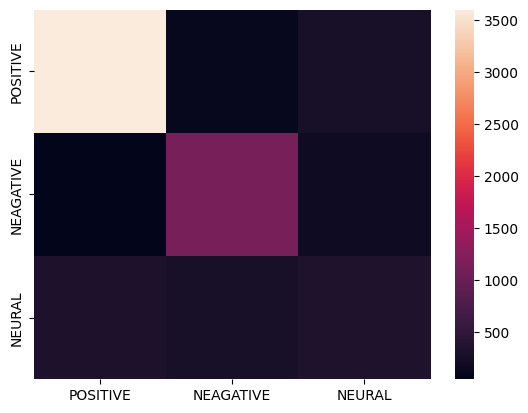

In [24]:
import seaborn as sns
class_names = ['POSITIVE','NEAGATIVE','NEURAL']
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels = class_names, yticklabels = class_names)

# Cac cau sai

In [25]:
for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(df_test.iloc[wrong_arr[i]].x_nomalized)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

--------------------------------------------------
quần xinh hơi ngắn chút
Predicted: (POSITIVE) --vs-- Real label: (NEURAL)
--------------------------------------------------
các pn nên mua ở shop
Predicted: (POSITIVE) --vs-- Real label: (NEURAL)
--------------------------------------------------
bạn nhận đc dày mình trả lại chưa
Predicted: (NEAGATIVE) --vs-- Real label: (NEURAL)
--------------------------------------------------
nghe review miêu_tả ghê_gớm lắm mà
Predicted: (NEAGATIVE) --vs-- Real label: (NEURAL)
--------------------------------------------------
shop đóng_gói chắc_chắn kèm cả hóa_đơn đỏ biết thế bảo shop xuất về cty
Predicted: (POSITIVE) --vs-- Real label: (NEURAL)
--------------------------------------------------
mà bản_thân ti cũng không muốn gửi trả lại shop lạch_cạch mất_công
Predicted: (NEAGATIVE) --vs-- Real label: (NEURAL)
--------------------------------------------------
mau thi giong hinh nhug hog dep nhu hih noi chug chi dc năm mươi phan tram trog hih th

#Demo

In [28]:
def pipeline(text,model,device = 'cuda'):
  text = tien_xu_li(text)
  encoded_review = tokenizer.encode_plus(
        text,
        max_length=120,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt')
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  model.eval()
  with torch.no_grad():
    output = model(input_ids, attention_mask)
    output = torch.softmax(output, dim=1)
    prob, y_pred = torch.max(output, dim=1)
  return prob.item(),class_names[y_pred]

In [29]:
try:
  import gradio as gr
except:
  !pip install gradio
  import gradio as gr

def predict(text):
  proba,predict = pipeline(text,model)

  return [predict,str(proba)]


demo = gr.Interface(predict,
                     inputs =
                       [gr.Textbox(label= "Nhập text")],
                     outputs = [gr.Textbox(label= "Sắc thái dự đoán"),gr.Textbox(label= "Độ tự tin")])
if __name__ == "__main__":

    demo.launch(share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3b9b5880381b0aa235.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
